In [1]:
import pandas as pd
import numpy as np
import alphalens
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib
from dateutil.relativedelta import relativedelta
from dataclasses import dataclass
import empyrical

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
os.chdir('../')

In [4]:
matplotlib.rcParams['font.sans-serif'] = ['Times New Roman'] 

#### 1.导入数据

In [5]:
alpha = pd.read_excel('./Output/alpha(Improved).xlsx',index_col = 0) # improved alpha
alpha.index = pd.to_datetime(alpha.index)

In [6]:
# 导入净值数据
# 基金数据，并分类到股票型基金
nv_2010to2014 = pd.read_csv("./Data/AdjustedNav(2010to2014).csv",index_col = 0)
nv_2015to2018 = pd.read_csv("./Data/AdjustedNav(2015to2018).csv",index_col = 0)
nv_2019to2022 = pd.read_csv("./Data/AdjustedNav(2019to2022).csv",index_col = 0)

In [7]:
nv = pd.concat([nv_2010to2014,nv_2015to2018,nv_2019to2022])
nv.index = pd.to_datetime(nv.index)
filled_nv = nv.asfreq("D").ffill()

In [8]:
# 导入基金经理离任数据
manager_info = pd.read_csv("./Data/ChinaMutualFundManager.csv",encoding = "gbk")
manager_info.F_INFO_MANAGER_LEAVEDATE = pd.to_datetime(manager_info.F_INFO_MANAGER_LEAVEDATE,format = '%Y%m%d')
manager_info.F_INFO_MANAGER_STARTDATE = pd.to_datetime(manager_info.F_INFO_MANAGER_STARTDATE,format = '%Y%m%d')
manager_useful_info = manager_info.loc[:,["F_INFO_WINDCODE","F_INFO_MANAGER_STARTDATE","F_INFO_MANAGER_LEAVEDATE"]]

In [9]:
# 导入货币市场基金，不买货币市场基金
# 导入股票型、偏股型和灵活配置型基金
currency_fund = pd.read_excel("./Data/CurrencyFund.xlsx",index_col = 0)
stk_mutual_fund = pd.read_excel("./Data/StkMutualFundInfo.xlsx",index_col = 0)

In [10]:
# fund scale
fund_scale = pd.read_excel("./Data/FundScale.xlsx",index_col = 0)

#### 2.回测

In [11]:
@dataclass
class FundClass:
    vt_symbol:str = " "
    buy_price:float = 0.0
    volume:int = 0
        
    def __post_init__(self):
        self.price = self.buy_price
        self.last_price = self.buy_price
        self.pnl = (self.price - self.buy_price)*self.volume
        self.daily_pnl = (self.price - self.last_price)*self.volume
        self.status = "HOLDING"
        self.type = ""

In [21]:
"""variables"""

"""paramaters"""
start_date = pd.to_datetime("2014-03-31")
end_date = pd.to_datetime("2021-12-31")
buy_cost:float = 0.005
sell_cost:float = 0.005
"""account infomation"""
in_position_fund:dict = {} 
balance:float = 300000.0
backtest_result:pd.DataFrame = pd.DataFrame(columns = ["ACCOUNT_NAV"])
style_series:pd.DataFrame = pd.DataFrame(index = pd.date_range(start_date,end_date),\
                                         columns = ["普通股票型基金","偏股混合型基金","灵活配置型基金"],\
                                         data = 0)

In [22]:
for date in pd.date_range(start_date,end_date): # 每天都进行循环更新
    
    if date in alpha.index and date.month % 3 == 0:
        # seasonal adjustment
        to_buy_position = alpha.loc[date].dropna().sort_values(ascending = False).iloc[:int(len(alpha.loc[date].dropna())*0.1)].index.tolist()
        for to_kick_fund in to_buy_position:
            if to_kick_fund in currency_fund.index:
                to_buy_position.remove(to_kick_fund)
            elif to_kick_fund not in stk_mutual_fund.index:
                to_buy_position.remove(to_kick_fund)
            elif fund_scale.at[date,to_kick_fund] < 3:
                to_buy_position.remove(to_kick_fund)
            elif stk_mutual_fund.at[to_kick_fund,"ESTABLISH_DATE"] <= date - relativedelta(years = 1):
                to_buy_position.remove(to_kick_fund)
            elif stk_mutual_fund.at[to_kick_fund,"IS_INITIAL"] == '否':
                to_buy_position.remove(to_kick_fund)
            else:
                try:
                    latest_manager_index = manager_useful_info.query(f"F_INFO_WINDCODE == '{to_kick_fund}' and \
                    F_INFO_MANAGER_STARTDATE <= '{date}'").F_INFO_MANAGER_STARTDATE.argmax()
                except ValueError:
                    continue
                latest_manager_start_date = manager_useful_info.query(f"F_INFO_WINDCODE == '{to_kick_fund}' and \
                F_INFO_MANAGER_STARTDATE <= '{date}'").F_INFO_MANAGER_STARTDATE.iloc[latest_manager_index]
                if latest_manager_start_date < date - relativedelta(months = 6):
                    to_buy_position.remove(to_kick_fund)
        
        # clear
        for to_sell_fund in in_position_fund.keys():
            # update when at the end of the month
            in_position_fund[to_sell_fund].last_price = in_position_fund[to_sell_fund].price
            in_position_fund[to_sell_fund].price = filled_nv.at[date,to_sell_fund]
            in_position_fund[to_sell_fund].pnl = (in_position_fund[to_sell_fund].price - \
                                                  in_position_fund[to_sell_fund].buy_price)*in_position_fund[to_sell_fund].volume
            in_position_fund[to_sell_fund].daily_pnl = (in_position_fund[to_sell_fund].price - \
                                                        in_position_fund[to_sell_fund].last_price)*in_position_fund[to_sell_fund].volume
            # sell
            if to_sell_fund not in to_buy_position:
                sell_price = filled_nv.at[date,to_sell_fund]
                print(f"sell {to_sell_fund} at {sell_price}")
                in_position_fund[to_sell_fund].status = "SOLD"
        
        # adjust
        for to_adjust_fund in in_position_fund.keys():
            if in_position_fund[to_adjust_fund].status == "HOLDING":
                price = filled_nv.at[date,to_adjust_fund]
                target_volume = balance/len(to_buy_position)/(price*(1+sell_cost))
                present_volume = in_position_fund[to_adjust_fund].volume
                if target_volume > present_volume:
                    pass
                else:
                    balance += (present_volume - target_volume)*(price - in_position_fund[to_adjust_fund].last_price)
                    balance -= (present_volume - target_volume)*price*sell_cost # sell cost
                    in_position_fund[to_adjust_fund].volume = target_volume
                    in_position_fund[to_adjust_fund].pnl = (in_position_fund[to_adjust_fund].price - \
                                                            in_position_fund[to_adjust_fund].buy_price) * in_position_fund[to_adjust_fund].volume
                    in_position_fund[to_adjust_fund].daily_pnl = (in_position_fund[to_adjust_fund].price - \
                                                                  in_position_fund[to_adjust_fund].last_price) * in_position_fund[to_adjust_fund].volume
                    print(f"adjust {to_adjust_fund} from {present_volume} to {target_volume}")

        # buy: not currency fund, must be in stk mutual fund
        for to_buy_fund in to_buy_position:
            if to_buy_fund not in in_position_fund.keys():
                buy_price = filled_nv.at[date,to_buy_fund]
                in_position_fund[to_buy_fund] = FundClass(
                    vt_symbol = to_buy_fund,
                    buy_price = buy_price,
                    volume = balance/len(to_buy_position)/(buy_price*(1+buy_cost)),
                )
                in_position_fund[to_buy_fund].type = stk_mutual_fund.at[to_buy_fund,"FUND_TYPE"]
                balance -= buy_price*(balance/len(to_buy_position)/buy_price)*buy_cost # buy cost
                print(f"buy {to_buy_fund} at {buy_price}")
                
    else:
        # 平日更新
        for to_adjust_fund in in_position_fund.keys():
            price = filled_nv.at[date,to_adjust_fund]
            in_position_fund[to_adjust_fund].last_price = in_position_fund[to_adjust_fund].price
            in_position_fund[to_adjust_fund].price = price
            in_position_fund[to_adjust_fund].pnl = (in_position_fund[to_adjust_fund].price - \
                                                    in_position_fund[to_adjust_fund].buy_price)*in_position_fund[to_adjust_fund].volume
            in_position_fund[to_adjust_fund].daily_pnl = (in_position_fund[to_adjust_fund].price - \
                                                          in_position_fund[to_adjust_fund].last_price)*in_position_fund[to_adjust_fund].volume
        
            if date in manager_useful_info.query(f"F_INFO_WINDCODE == '{to_adjust_fund}'").F_INFO_MANAGER_LEAVEDATE.tolist(): # manager transfer
                sell_price = filled_nv.at[date,to_adjust_fund]
                print(f"sell {to_adjust_fund} at {sell_price}")
                in_position_fund[to_adjust_fund].status = "SOLD"
            
    for to_compute_pnl_fund in list(in_position_fund.keys()):
        balance += in_position_fund[to_compute_pnl_fund].daily_pnl
        style_series.loc[date,in_position_fund[to_compute_pnl_fund].type] += 1
        if in_position_fund[to_compute_pnl_fund].status == "SOLD":
            balance -= in_position_fund[to_compute_pnl_fund].price*in_position_fund[to_compute_pnl_fund].volume*sell_cost # sell cost
            del in_position_fund[to_compute_pnl_fund]
    backtest_result.loc[date,"ACCOUNT_NAV"] = balance

buy 163412.OF at 1.764
buy 180031.OF at 1.4808
buy 590008.OF at 2.099
buy 400007.OF at 1.3065
buy 000251.OF at 1.141
buy 530011.OF at 0.927
buy 210003.OF at 0.7772
buy 165313.OF at 0.894
buy 160505.OF at 5.03407123
buy 000390.OF at 1.0671
buy 202005.OF at 2.59401473
buy 160916.OF at 0.8113
buy 970020.OF at 0.837
buy 420003.OF at 1.2285
buy 630010.OF at 1.2795
buy 163411.OF at 1.1332
buy 850004.OF at 0.7156
buy 000526.OF at 1.003
buy 519670.OF at 2.2797
buy 090001.OF at 3.85219555
buy 519125.OF at 1.034
buy 000165.OF at 1.0649
buy 000433.OF at 1.017
buy 000072.OF at 1.003
buy 320006.OF at 1.74310522
buy 040016.OF at 0.9293
buy 910028.OF at 1.0067
buy 000066.OF at 0.997
buy 952009.OF at 1.1574972
buy 320020.OF at 1.061
buy 000314.OF at 1.008
buy 050010.OF at 1.17833081
buy 160624.OF at 0.9027
sell 163412.OF at 1.741
sell 180031.OF at 1.5164
sell 590008.OF at 2.628
sell 530011.OF at 0.963
sell 210003.OF at 0.7874
sell 165313.OF at 0.93
sell 160505.OF at 5.3583519
sell 000390.OF at 1.0519


sell 000828.OF at 1.4176
sell 000538.OF at 1.222
sell 000939.OF at 1.2536
sell 001007.OF at 1.028
sell 257050.OF at 1.747
sell 540002.OF at 5.3509876
sell 540003.OF at 2.63573435
sell 000763.OF at 1.319
sell 000195.OF at 1.391
sell 519087.OF at 8.61856366
sell 519093.OF at 2.571
sell 519050.OF at 1.324
sell 000664.OF at 1.1753
sell 000417.OF at 1.2546
sell 000556.OF at 1.3212
sell 000824.OF at 1.8292
sell 163411.OF at 1.40303636
sell 000251.OF at 2.757
sell 001017.OF at 1.452
sell 860018.OF at 2.3794
sell 000963.OF at 1.295
sell 860006.OF at 2.24799146
sell 050201.OF at 2.48723138
sell 260109.OF at 5.13214555
sell 253010.OF at 2.22181367
sell 000926.OF at 1.187
sell 519975.OF at 1.287
sell 000684.OF at 1.538
sell 000849.OF at 1.4373
sell 000850.OF at 1.4274
sell 050010.OF at 2.47157517
sell 169101.OF at 1.7376
sell 000845.OF at 1.5124
sell 001067.OF at 1.057
sell 000825.OF at 1.8063
sell 000991.OF at 1.114
sell 000172.OF at 2.4289
sell 000878.OF at 1.671
sell 162207.OF at 3.69290416
se

sell 610002.OF at 2.08060017
sell 610005.OF at 1.0797
sell 001181.OF at 0.815
sell 050001.OF at 3.90291072
sell 001564.OF at 0.939
sell 001110.OF at 1.329
sell 001289.OF at 1.262
sell 501001.OF at 1.019
sell 001371.OF at 0.94
sell 180012.OF at 3.1577519
sell 161224.OF at 1.1358
sell 002025.OF at 1.075
sell 540006.OF at 2.3094
sell 002026.OF at 1.018
sell 750001.OF at 1.7117
sell 001712.OF at 0.912
sell 001583.OF at 1.001
sell 161225.OF at 0.903
sell 001523.OF at 1.028
sell 233007.OF at 2.31
sell 001569.OF at 0.86
sell 001682.OF at 0.985
sell 162414.OF at 1.0302
sell 001623.OF at 0.914
sell 001407.OF at 1.046
sell 910028.OF at 1.8316
sell 001430.OF at 1.061
sell 001688.OF at 0.966
sell 160611.OF at 1.00798438
sell 260112.OF at 1.8295
sell 001194.OF at 1.054
sell 001858.OF at 1.001
sell 001967.OF at 1.001
sell 001405.OF at 1.034
sell 001379.OF at 1.03239391
sell 001338.OF at 1.09
sell 340008.OF at 2.7448
sell 001535.OF at 0.952
sell 001499.OF at 1.0342
sell 001226.OF at 1.143
sell 001531

sell 001810.OF at 1.146
sell 001074.OF at 0.8727
sell 168101.OF at 1.337
sell 001694.OF at 1.209
sell 959993.OF at 1.67985487
sell 110025.OF at 0.92
sell 000172.OF at 2.0926
sell 002207.OF at 1.182
sell 100022.OF at 7.495154
sell 002134.OF at 1.096
sell 519767.OF at 1.093
sell 398061.OF at 2.5522
sell 000423.OF at 1.098
sell 519022.OF at 1.2671
sell 001875.OF at 1.163
sell 519963.OF at 1.139
sell 001955.OF at 1.063
sell 001463.OF at 0.832
sell 001371.OF at 1.033
sell 001559.OF at 0.7339
sell 002449.OF at 1.031
sell 001827.OF at 1.104
sell 001528.OF at 1.073
sell 519710.OF at 1.173
sell 001178.OF at 1.107
sell 001882.OF at 2.203
sell 000991.OF at 0.957
sell 001054.OF at 0.969
sell 860016.OF at 1.389774
sell 001864.OF at 1.074
sell 002214.OF at 1.125
sell 110022.OF at 1.365
sell 001701.OF at 1.012
sell 001975.OF at 1.178
sell 410001.OF at 3.26891027
sell 530003.OF at 4.04209873
sell 000850.OF at 1.709
sell 001677.OF at 1.039
sell 002244.OF at 1.2066
sell 000309.OF at 1.787
sell 233001.OF

sell 080008.OF at 1.9814
sell 003582.OF at 1.027
sell 001104.OF at 0.981
sell 310328.OF at 3.76604322
sell 398021.OF at 0.99252255
sell 519185.OF at 2.3732
sell 001518.OF at 1.9268
sell 240022.OF at 1.303
sell 673071.OF at 1.2318
sell 002207.OF at 1.11
sell 002780.OF at 1.025
sell 001638.OF at 1.004
sell 000363.OF at 2.2391
sell 690007.OF at 2.119
sell 160421.OF at 0.9417
sell 001626.OF at 1.091
sell 001535.OF at 1.066
sell 050010.OF at 2.09401211
sell 519191.OF at 1.183
sell 160512.OF at 2.6362
sell 960026.OF at 1.029
sell 519772.OF at 1.016
sell 002564.OF at 1.06350841
sell 002594.OF at 1.007
sell 001437.OF at 1.413
sell 001438.OF at 1.163
sell 202005.OF at 5.77031279
sell 002118.OF at 1.009
sell 519195.OF at 1.3046
sell 001074.OF at 0.9642
sell 001998.OF at 1.001
sell 001715.OF at 1.004
sell 180012.OF at 4.30785046
sell 519181.OF at 2.04652619
sell 003373.OF at 0.9995
sell 000172.OF at 2.3083
sell 001759.OF at 1.02
sell 519778.OF at 1.0513
sell 003374.OF at 0.999
sell 540002.OF at 4

sell 519157.OF at 1.401
sell 519156.OF at 3.0037
sell 481008.OF at 1.8287
sell 001897.OF at 1.194
sell 001388.OF at 1.015
sell 001823.OF at 1.061
sell 000893.OF at 0.716
sell 001283.OF at 1.1823
sell 001284.OF at 1.1008
sell 004046.OF at 1.0759
sell 410009.OF at 1.0322
sell 001657.OF at 1.251
sell 001974.OF at 1.365
sell 860006.OF at 2.02670944
sell 000904.OF at 1.2895
sell 001303.OF at 1.128
sell 002424.OF at 1.026
sell 002207.OF at 1.003
sell 001789.OF at 1.098
sell 004634.OF at 1.1005
sell 004423.OF at 1.014
sell 002071.OF at 1.1741
sell 004320.OF at 1.0668
sell 001121.OF at 0.7005
sell 002161.OF at 1.0341
sell 002952.OF at 1.0765
sell 000688.OF at 1.4986
sell 001359.OF at 1.1208
sell 003858.OF at 1.098
sell 003446.OF at 1.2034
sell 090003.OF at 3.88328274
sell 003154.OF at 1.2058
sell 001608.OF at 1.0347
sell 001056.OF at 0.977
sell 110025.OF at 1.147
sell 003624.OF at 1.3232
sell 003416.OF at 0.8881
sell 003865.OF at 1.1923
sell 001917.OF at 1.1038
sell 002319.OF at 1.041
sell 000

sell 003886.OF at 1.2691
sell 003887.OF at 1.246
sell 001008.OF at 1.146
sell 000557.OF at 1.5059
sell 000556.OF at 1.5375
sell 000531.OF at 1.458
sell 519193.OF at 1.3081
sell 002772.OF at 1.076
sell 001380.OF at 1.6359
sell 952004.OF at 2.41755406
sell 900008.OF at 1.90438855
sell 001596.OF at 1.117
sell 003447.OF at 1.2231
sell 004987.OF at 1.1164
sell 002686.OF at 1.1653
sell 000264.OF at 0.9167
sell 001306.OF at 0.94
sell 870017.OF at 1.74226225
sell 003170.OF at 1.1016
sell 260110.OF at 1.70247484
sell 005236.OF at 0.9416
sell 005235.OF at 0.9406
sell 005037.OF at 0.8912
sell 003119.OF at 1.243
sell 000904.OF at 1.2651
sell 004505.OF at 1.228
sell 210001.OF at 3.9266937
sell 005245.OF at 0.9521
sell 005244.OF at 0.9541
sell 001890.OF at 0.905
sell 320018.OF at 1.8484
sell 005000.OF at 0.9901
sell 002124.OF at 1.357
sell 005343.OF at 0.9788
sell 004609.OF at 1.0127
sell 004724.OF at 1.0596
sell 005186.OF at 0.9741
sell 005187.OF at 0.9732
sell 003951.OF at 1.1079
sell 003950.OF at

sell 001951.OF at 0.938
sell 004359.OF at 1.0399
sell 001887.OF at 2.213
sell 519007.OF at 2.01824863
sell 001763.OF at 0.869
sell 005042.OF at 0.9775
sell 001966.OF at 0.928
sell 000866.OF at 1.03
sell 260111.OF at 1.9607
sell 001393.OF at 1.0313
sell 519621.OF at 0.9346
sell 166024.OF at 0.9357
sell 001441.OF at 0.85
sell 001562.OF at 0.97
sell 001614.OF at 0.7595
sell 005764.OF at 1.33168811
sell 002653.OF at 1.26415028
sell 005260.OF at 0.8265
sell 005400.OF at 0.8945
sell 161224.OF at 0.97830932
sell 519193.OF at 1.164
sell 004209.OF at 0.9826
sell 005267.OF at 0.9559
sell 001008.OF at 1.022
sell 003591.OF at 1.102
sell 000916.OF at 1.3267999
sell 260117.OF at 1.46509235
sell 003805.OF at 1.0977
sell 260108.OF at 3.16361375
sell 860016.OF at 1.278814
sell 001117.OF at 0.818
sell 005095.OF at 0.8514
sell 001865.OF at 1.183
sell 240022.OF at 1.37360252
sell 003625.OF at 0.9452
sell 001121.OF at 0.5571
sell 003835.OF at 1.086
sell 006104.OF at 1.0099
sell 001158.OF at 0.62
sell 00284

sell 001583.OF at 1.06484249
sell 090018.OF at 1.88499321
sell 001518.OF at 1.95578065
sell 003026.OF at 1.22914944
sell 003027.OF at 1.22199147
sell 001208.OF at 0.985
sell 001442.OF at 0.876
sell 400001.OF at 4.5300771
sell 001004.OF at 0.913
sell 004871.OF at 1.0529
sell 002849.OF at 1.139
sell 005506.OF at 1.3631
sell 519150.OF at 3.06509058
sell 002558.OF at 1.372
sell 001802.OF at 1.20153264
sell 004505.OF at 1.405
sell 005901.OF at 1.1491
sell 001185.OF at 1.3296
sell 005541.OF at 1.30594586
sell 005542.OF at 1.30407013
sell 006181.OF at 1.0533
sell 006587.OF at 1.007
sell 001117.OF at 0.99
sell 004496.OF at 1.2814
sell 003304.OF at 1.214
sell 001728.OF at 1.258
sell 005840.OF at 1.2075
sell 001449.OF at 1.26462841
sell 002289.OF at 1.1062
sell 501062.OF at 1.0693
sell 005669.OF at 1.0181
sell 006217.OF at 1.5479
sell 006216.OF at 1.5486
sell 001942.OF at 1.464
sell 000979.OF at 1.102
sell 000574.OF at 2.13446406
sell 255010.OF at 5.39351211
sell 005038.OF at 0.8088
sell 360007.

sell 001902.OF at 1.04507063
sell 001901.OF at 1.0421749
sell 005489.OF at 1.1194
sell 003889.OF at 2.022
sell 001359.OF at 1.07251974
sell 003304.OF at 1.35529412
sell 000884.OF at 1.411
sell 000805.OF at 1.084
sell 163810.OF at 1.75075539
sell 006323.OF at 1.0816
sell 005076.OF at 1.0042
sell 004112.OF at 0.99
sell 002314.OF at 1.22320052
sell 006796.OF at 1.147
sell 005680.OF at 1.1833
sell 110022.OF at 2.886
sell 200008.OF at 1.57315183
sell 000083.OF at 4.426
sell 005379.OF at 1.2776
sell 870017.OF at 1.92307675
sell 580008.OF at 1.989
sell 006253.OF at 1.4295
sell 005267.OF at 1.0635
sell 006601.OF at 1.04483217
sell 004815.OF at 0.9946
sell 970020.OF at 1.127
sell 860007.OF at 1.8018242
sell 007082.OF at 1.1346
sell 001302.OF at 0.979
sell 004497.OF at 1.3006
sell 007120.OF at 1.0977
sell 007119.OF at 1.1
sell 006775.OF at 1.0127
sell 005506.OF at 1.4028
sell 398061.OF at 3.2448805
sell 000462.OF at 1.1976
sell 003298.OF at 1.377
sell 003299.OF at 1.369
sell 006314.OF at 1.1681


sell 005344.OF at 1.0953
sell 006038.OF at 1.398
sell 860018.OF at 1.5974
sell 001638.OF at 1.428
sell 006981.OF at 1.2268
sell 005541.OF at 1.54970046
sell 006759.OF at 1.1922
sell 006595.OF at 1.1661
sell 920011.OF at 2.60319392
sell 004480.OF at 1.0727
sell 002303.OF at 1.127
sell 860016.OF at 1.518765
sell 007527.OF at 1.0936
sell 001728.OF at 1.454
sell 007381.OF at 1.0842
sell 007553.OF at 1.091
sell 007412.OF at 1.0711
sell 006768.OF at 1.2565
sell 006753.OF at 1.0964
sell 519196.OF at 1.63343859
sell 007494.OF at 1.0948
sell 007493.OF at 1.0982
sell 000690.OF at 1.219
sell 163809.OF at 1.77203333
sell 000904.OF at 1.4318905
sell 006537.OF at 1.0236
sell 003413.OF at 1.5784
sell 004263.OF at 1.81403828
sell 002269.OF at 0.828
sell 007368.OF at 1.1483
sell 002685.OF at 1.45755557
sell 003580.OF at 1.2672
sell 007460.OF at 1.3108
sell 040015.OF at 3.07542427
sell 005170.OF at 1.4051
sell 007632.OF at 1.364
sell 001685.OF at 1.101
sell 002293.OF at 1.3904
sell 673090.OF at 1.378544

sell 004836.OF at 1.0417
sell 007570.OF at 1.1852
sell 730002.OF at 1.47142079
sell 006879.OF at 1.5012
sell 001273.OF at 0.885
sell 007291.OF at 1.0424
sell 002686.OF at 1.29914765
sell 005726.OF at 1.4818
sell 007254.OF at 1.0801
sell 006781.OF at 0.9518
sell 005707.OF at 0.8797
sell 002332.OF at 1.25604754
sell 002333.OF at 1.230478
sell 005571.OF at 1.1114
sell 257040.OF at 1.93747349
sell 001635.OF at 1.3945
sell 501054.OF at 1.0663
sell 001682.OF at 1.3016091
sell 005937.OF at 1.1502
sell 005938.OF at 1.1311
sell 001048.OF at 1.216
sell 006449.OF at 1.3133
sell 007132.OF at 0.95359273
sell 004848.OF at 1.1445
sell 003834.OF at 1.046
sell 006462.OF at 1.2354
sell 005939.OF at 1.255
sell 003625.OF at 0.9749
sell 001643.OF at 1.2141
sell 400015.OF at 1.59653293
sell 003624.OF at 0.9925
sell 004640.OF at 0.9242
sell 007518.OF at 1.0898
sell 007549.OF at 1.0638
sell 001302.OF at 0.984
sell 002207.OF at 0.968
sell 005660.OF at 1.0961
sell 005661.OF at 1.0892
sell 003984.OF at 1.369
sel

sell 000220.OF at 3.885
sell 001857.OF at 1.417
sell 001030.OF at 1.0013
sell 006205.OF at 1.3302
sell 006819.OF at 1.2644
sell 005646.OF at 1.0846
sell 003304.OF at 1.56885562
sell 270041.OF at 3.891
sell 003025.OF at 1.57751899
sell 008314.OF at 1.3241
sell 009132.OF at 2.9961
sell 008107.OF at 1.3501
sell 501087.OF at 1.2827
sell 008353.OF at 1.2058
sell 001717.OF at 3.371
sell 006003.OF at 2.7492
sell 006676.OF at 1.3771
sell 008293.OF at 1.3865
sell 006228.OF at 2.1618
sell 860006.OF at 2.74181386
sell 004424.OF at 2.0412
sell 000727.OF at 2.762
sell 005303.OF at 2.0225
sell 005304.OF at 1.9828
sell 000960.OF at 2.682
sell 003096.OF at 3.04666459
sell 003095.OF at 3.05897662
sell 163001.OF at 2.93868085
sell 005621.OF at 2.156
sell 005827.OF at 1.9677
sell 005847.OF at 1.6289
sell 003581.OF at 1.763
sell 008251.OF at 1.1786
sell 519171.OF at 1.543
sell 007481.OF at 1.3476
sell 008252.OF at 1.1756
sell 003032.OF at 1.8624
sell 006753.OF at 1.1907
sell 005794.OF at 2.06605588
sell 0

sell 002778.OF at 0.88966661
sell 002779.OF at 1.61310917
sell 004833.OF at 1.0642
sell 004834.OF at 1.0478
sell 001162.OF at 1.552
sell 000273.OF at 2.40555192
sell 007632.OF at 1.5728
sell 003955.OF at 2.2505
sell 004357.OF at 2.0575
sell 005109.OF at 1.51897143
sell 005110.OF at 1.49893576
sell 006271.OF at 1.3582
sell 519613.OF at 1.4468
sell 005726.OF at 2.1951
sell 002621.OF at 2.925
sell 002697.OF at 2.918
sell 519212.OF at 1.5119
sell 519714.OF at 2.38104361
sell 008061.OF at 1.3157
sell 952035.OF at 1.81983381
sell 001832.OF at 1.994
sell 005450.OF at 1.6946
sell 110022.OF at 4.083
sell 001927.OF at 2.699
sell 005812.OF at 1.948
sell 070032.OF at 4.7835709
sell 006642.OF at 2.22147762
sell 009098.OF at 1.1786
sell 009126.OF at 1.1103
sell 009025.OF at 0.9987
sell 008277.OF at 1.26
sell 006967.OF at 1.2716
sell 008657.OF at 1.336
sell 860018.OF at 2.151
sell 009137.OF at 1.3164
sell 008655.OF at 1.1364
sell 008671.OF at 1.2474
sell 006976.OF at 1.7971
sell 519020.OF at 1.984894

sell 005583.OF at 1.0515
sell 002778.OF at 0.99582851
sell 006269.OF at 1.916
sell 350007.OF at 1.663
sell 007368.OF at 1.5711
sell 007369.OF at 1.5574
sell 005335.OF at 1.8099
sell 000574.OF at 4.00569259
sell 270007.OF at 2.65458901
sell 004685.OF at 1.8544
sell 008271.OF at 1.6906
sell 001217.OF at 3.664
sell 168104.OF at 2.22550246
sell 005165.OF at 2.0345
sell 000529.OF at 4.255
sell 003890.OF at 3.9457
sell 007084.OF at 2.0456
sell 160921.OF at 1.67279659
sell 006386.OF at 2.1987
sell 006442.OF at 1.637007
sell 008063.OF at 1.6432
sell 000520.OF at 3.54984132
sell 007944.OF at 1.3095
sell 002190.OF at 2.789
sell 008372.OF at 1.4521
sell 010021.OF at 2.5355
sell 008878.OF at 1.1716
sell 000904.OF at 2.45063696
sell 009645.OF at 1.309
sell 009644.OF at 1.3123
sell 501065.OF at 2.58806523
sell 260104.OF at 26.37607913
sell 009707.OF at 1.2526
sell 010059.OF at 1.211
sell 910028.OF at 4.61494859
sell 006605.OF at 2.2275
sell 005267.OF at 2.0775
sell 007047.OF at 2.31311132
sell 00172

sell 162203.OF at 15.15226719
sell 005851.OF at 1.7776
sell 005959.OF at 1.7409
sell 519125.OF at 2.747
sell 008704.OF at 1.3144
sell 008705.OF at 1.309
sell 002685.OF at 2.32065258
sell 006179.OF at 2.4605
sell 004814.OF at 1.6108
sell 004815.OF at 1.5776
sell 001373.OF at 2.052
sell 007534.OF at 1.61032125
sell 004943.OF at 1.8271
sell 005235.OF at 2.4461
sell 010135.OF at 0.8381
sell 002024.OF at 1.26633333
sell 006167.OF at 1.96771517
sell 005004.OF at 2.2277
sell 920002.OF at 7.33659875
sell 001473.OF at 3.0745
sell 008062.OF at 1.4678
sell 260109.OF at 11.69832984
sell 007412.OF at 1.9506
sell 009714.OF at 1.1935
sell 001384.OF at 1.7195
sell 004987.OF at 2.1768
sell 006397.OF at 3.26251759
sell 007548.OF at 1.8288
sell 004995.OF at 1.9663
sell 040016.OF at 5.19976022
sell 008371.OF at 1.7897
sell 006752.OF at 1.4932
sell 006753.OF at 1.4847
sell 001543.OF at 2.998
sell 008290.OF at 1.5122
sell 008353.OF at 1.75990762
sell 007523.OF at 1.6959
sell 008174.OF at 1.6093
sell 007524.

sell 000993.OF at 1.567
sell 006881.OF at 2.2523
sell 240020.OF at 5.22498125
sell 420003.OF at 4.92119537
sell 000946.OF at 2.987
sell 002264.OF at 2.505
sell 003032.OF at 2.4745
sell 006803.OF at 1.4722
sell 160144.OF at 1.088
sell 009859.OF at 0.9999
sell 004138.OF at 2.2109
sell 260108.OF at 9.29596374
sell 001857.OF at 2.408
sell 070018.OF at 3.93227464
sell 610005.OF at 2.46704289
sell 010151.OF at 1.1718
sell 009548.OF at 1.3596
sell 005596.OF at 2.3998
sell 005597.OF at 2.3609
sell 003190.OF at 2.86911145
sell 009141.OF at 1.2538
sell 010809.OF at 1.1191
sell 010808.OF at 1.1204
sell 160143.OF at 1.3819
sell 010275.OF at 1.2523
sell 160529.OF at 1.3362
sell 011308.OF at 2.7509
sell 010393.OF at 1.2633
sell 010394.OF at 1.2568
sell 001717.OF at 5.047
sell 004040.OF at 2.91556267
sell 011556.OF at 2.0908
sell 001171.OF at 2.449
sell 006003.OF at 3.8343
sell 009852.OF at 1.1846
sell 002300.OF at 3.072
sell 005303.OF at 2.8175
sell 010454.OF at 1.0903
sell 011453.OF at 3.4326
sell 

sell 001135.OF at 1.342
sell 560003.OF at 1.75138857
sell 005671.OF at 2.83676362
sell 005672.OF at 2.76840904
sell 002780.OF at 3.335
sell 004634.OF at 2.3618
sell 003333.OF at 1.2925
sell 003567.OF at 3.6519
sell 012200.OF at 1.1268
sell 002165.OF at 1.70826415
sell 008251.OF at 1.7202
sell 008252.OF at 1.7057
sell 002216.OF at 1.806
sell 001188.OF at 1.374
sell 004986.OF at 2.37312686
sell 002419.OF at 2.27137075
sell 010090.OF at 1.2194
sell 001230.OF at 1.295
sell 003291.OF at 2.896
sell 002408.OF at 3.0552
sell 008413.OF at 1.1505
sell 009848.OF at 1.2187
sell 005450.OF at 1.9095
sell 005236.OF at 2.4259
sell 003887.OF at 2.48631526
sell 005535.OF at 3.385
sell 200006.OF at 4.66188746
sell 007141.OF at 1.4947
sell 007142.OF at 1.4843
sell 009840.OF at 1.1557
sell 011458.OF at 1.1439
sell 011355.OF at 0.9978
sell 009437.OF at 1.6473
sell 011144.OF at 1.1073
sell 011599.OF at 1.0329
sell 009684.OF at 1.4745
sell 009696.OF at 1.1725
sell 012799.OF at 2.0775
sell 012631.OF at 1.9628


sell 004905.OF at 3.2332
sell 010031.OF at 3.2053
sell 011453.OF at 3.1023
sell 007423.OF at 1.0184
sell 008166.OF at 1.4823
sell 008167.OF at 1.4627
sell 007718.OF at 1.824
sell 010500.OF at 1.8171
sell 005689.OF at 2.92173
sell 010321.OF at 1.2124
sell 004403.OF at 1.5362
sell 005176.OF at 3.2379
sell 007151.OF at 1.4099


#### 3.作图

In [14]:
long_backtest_result = backtest_result
# short_backtest_result = backtest_result
# 300000*long_backtest_result.ACCOUNT_NAV/short_backtest_result.ACCOUNT_NAV

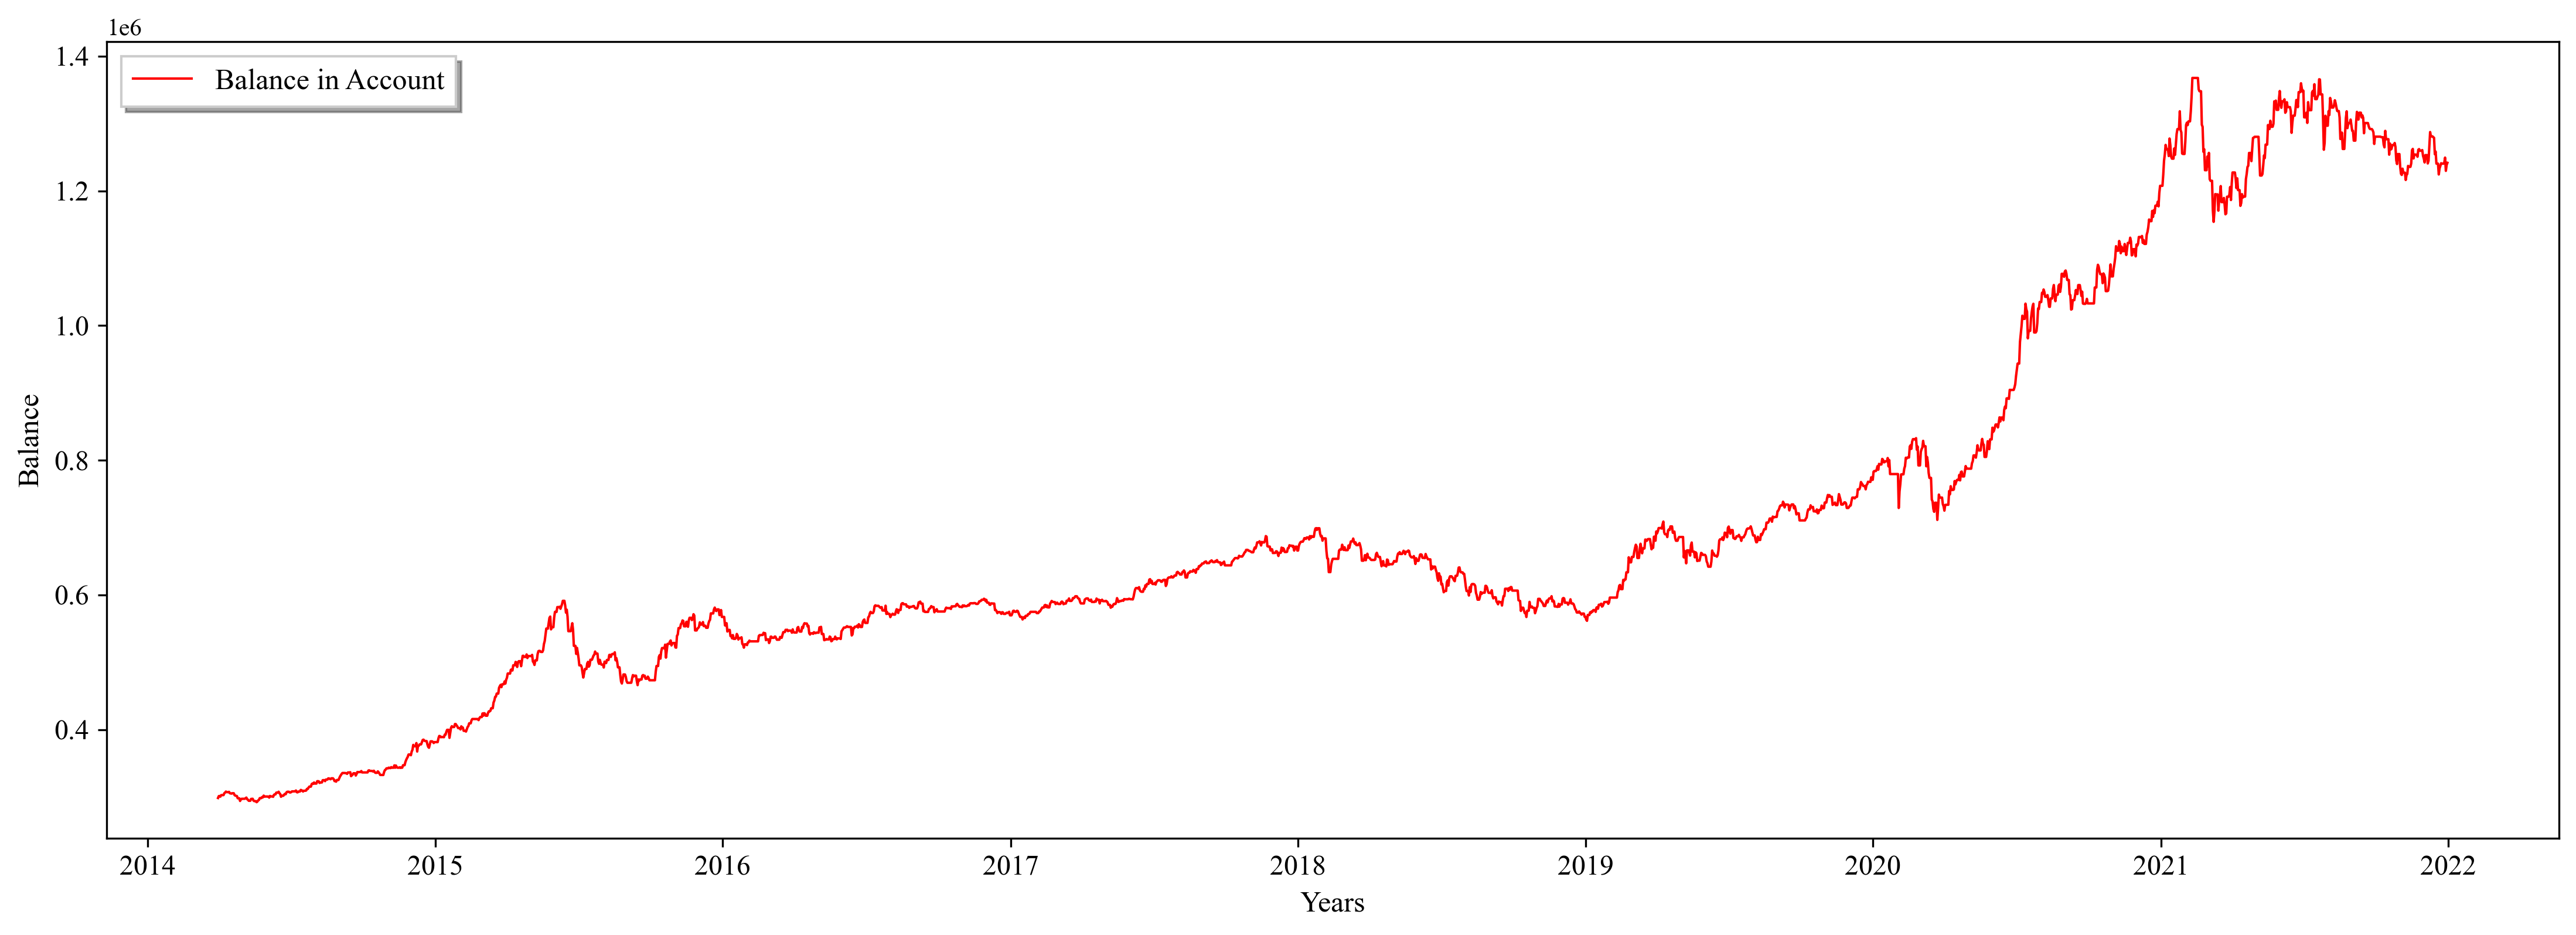

In [15]:
# plot
fig = plt.figure(figsize = (18,6),dpi = 300)
ax1 = fig.add_subplot(111)
ax1.plot(long_backtest_result.ACCOUNT_NAV, "-",color = "red",linewidth = 1,label = "Net Value")
# ax1.plot(short_backtest_result.ACCOUNT_NAV, "-",color = "#0000FF",linewidth = 1,label = "Net Value")
# ax1.plot(300000*long_backtest_result.ACCOUNT_NAV/short_backtest_result.ACCOUNT_NAV, "--",color = "orange",linewidth = 1,label = "Net Value")
plt.xticks(fontproperties='Times New Roman', size = 11.5)
plt.yticks(fontproperties='Times New Roman', size = 11.5)
ax1.set_ylabel("Balance",fontsize = 12)
ax1.set_xlabel("Years",fontsize = 12)
ax1.legend(["Balance in Account"], loc = 'upper left',fontsize = 12,shadow = "gray",fancybox = False)
# plt.savefig("./Plot/BalanceInAccount(SelfMade(Improved)).png")

#### 4.风险收益指标

In [16]:
# Sharpe
rf = 0.00011741094678452413
empyrical.sharpe_ratio(long_backtest_result.ACCOUNT_NAV.pct_change().dropna().values, risk_free = rf, period = 'daily', annualization = 365)

0.9934570153260659

In [17]:
# annual return
empyrical.annual_return(long_backtest_result.ACCOUNT_NAV.pct_change().dropna().values,period = 'daily',annualization = 365)

0.20168500782848575

In [18]:
# max drawdown
((long_backtest_result.ACCOUNT_NAV.cummax() - long_backtest_result.ACCOUNT_NAV)/(long_backtest_result.ACCOUNT_NAV.cummax())).max()

0.2117374323468892

#### 5.基金风格作图

In [45]:
plt.rcParams["font.sans-serif"] = ["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"] = False #该语句解决图像中的“-”负号的乱码问题

In [34]:
pct_style_series = np.transpose(np.transpose(style_series)/style_series.sum(axis = 1))

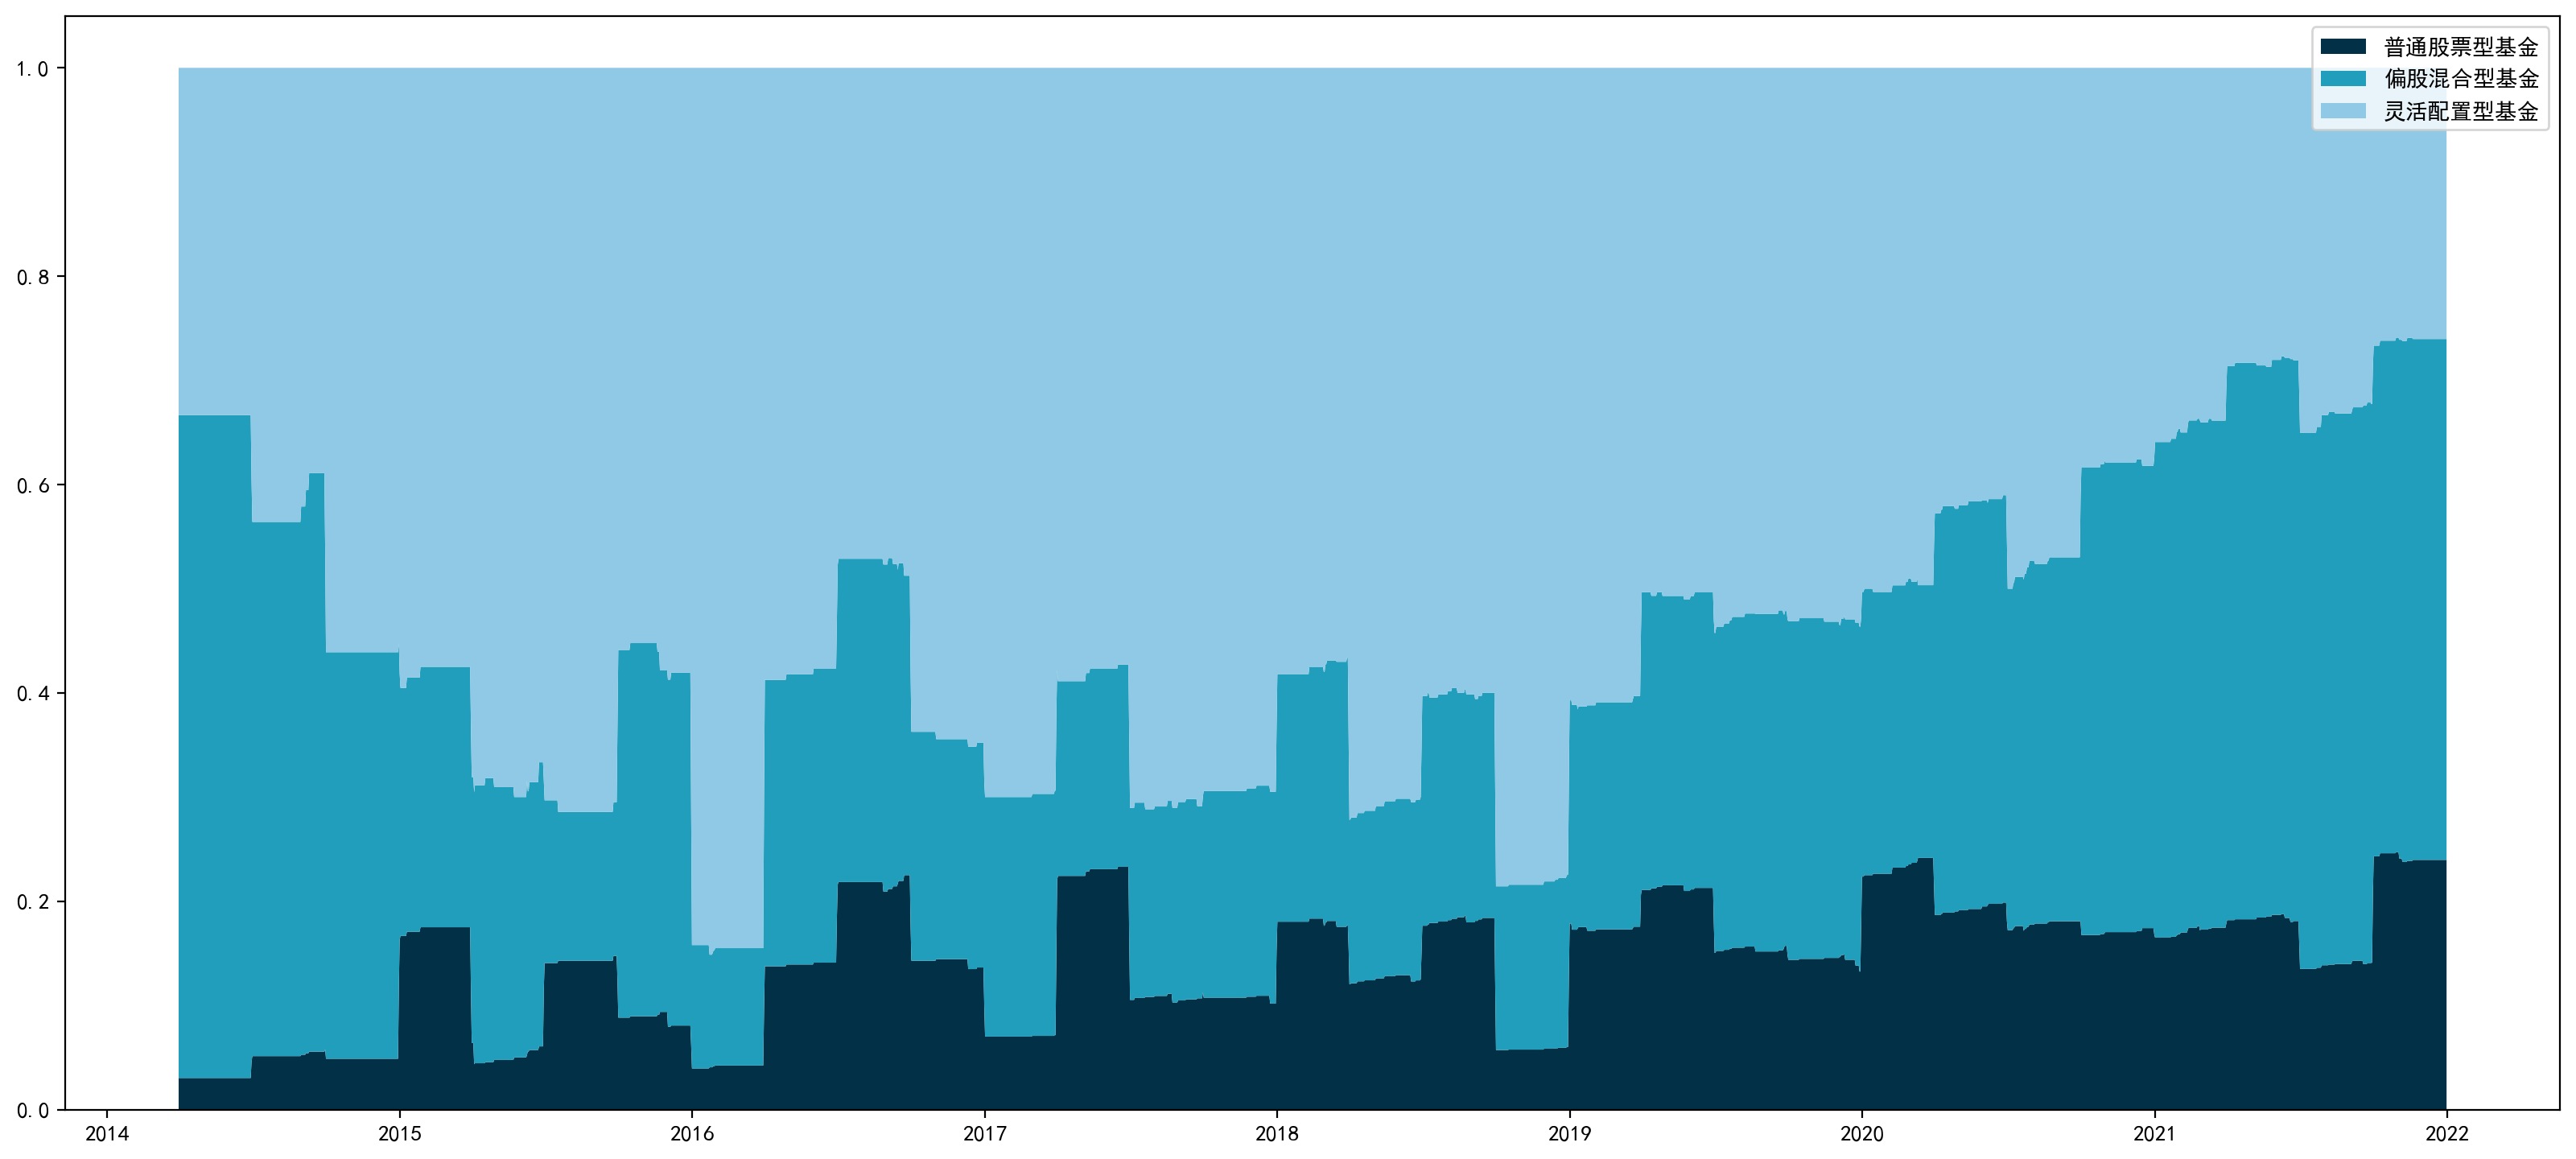

In [50]:
plt.figure(figsize = (20,9),dpi = 200)
plt.stackplot(pct_style_series.index,pct_style_series.普通股票型基金,pct_style_series.偏股混合型基金,pct_style_series.灵活配置型基金,\
              baseline = 'zero', labels = ['普通股票型基金', '偏股混合型基金', '灵活配置型基金'], 
              colors = [(2/255, 48/255, 71/255),(33/255, 158/255, 188/255),(144/255, 201/255, 230/255)])
plt.legend()
plt.savefig('./Plot/FundStyleSeries',bbox_inches='tight',dpi=fig.dpi,pad_inches=0.0)